In [63]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

import sys, os
# This is not super pretty, but I think this is the best way to import stuff from ../../../util?
CODE_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if CODE_ROOT not in sys.path:
    sys.path.insert(1, CODE_ROOT)

from util.spectra_helpers import SpectraCustomHDF5
from util.sim_data_helpers import get_cosmo_parameters

from first_tranformer_test import *

In [64]:
suite_to_use = "L25n256_suite"

In [65]:
index_list = np.array(list(range(50)))
np.random.seed(42)
np.random.shuffle(index_list)

n_train = int(0.7 * len(index_list))
n_eval  = int(0.15 * len(index_list))

train_gps = index_list[:n_train]
eval_gps  = index_list[n_train:n_train + n_eval]
test_gps  = index_list[n_train + n_eval:]

In [66]:
def build_dataset_for_gridpoints(gridpoints, suite_to_use):
    X, y = [], []

    for i in gridpoints:
        path_to_file = f"/vera/ptmp/gc/jerbo/training_data/{suite_to_use}/gp{i}_spectra.hdf5"
        spec_file = SpectraCustomHDF5(path_to_file)
        _, flux = spec_file.get_all_spectra()  # (1000, 468)
        flux = flux[:1000]

        params = get_cosmo_parameters(
            f"/vera/ptmp/gc/jerbo/{suite_to_use}/gridpoint{i}/"
        )

        for spec in flux:
            X.append(spec)
            y.append(params)

    return np.array(X), np.array(y)

In [67]:
class SpectraCosmoDataset(Dataset):
    def __init__(self, X, y, dtype=torch.float32):
        self.X = torch.tensor(X, dtype=dtype)
        self.y = torch.tensor(y, dtype=dtype)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [68]:
X_train, y_train = build_dataset_for_gridpoints(train_gps, suite_to_use)
X_eval,  y_eval  = build_dataset_for_gridpoints(eval_gps,  suite_to_use)
X_test,  y_test  = build_dataset_for_gridpoints(test_gps,  suite_to_use)

In [69]:
print(X_train.shape)

(35000, 464)


In [70]:
train_dataset = SpectraCosmoDataset(X_train, y_train)
eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
test_dataset  = SpectraCosmoDataset(X_test,  y_test)

X_mean = train_dataset.X.mean(dim=0)
X_std  = train_dataset.X.std(dim=0) + 1e-8

y_mean = train_dataset.y.mean(dim=0)
y_std  = train_dataset.y.std(dim=0) + 1e-8

def normalize(dataset):
    dataset.X = (dataset.X - X_mean) / X_std
    dataset.y = (dataset.y - y_mean) / y_std

normalize(train_dataset)
normalize(eval_dataset)
normalize(test_dataset)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
)


In [71]:
# Extract unique cosmologies
train_cosmo = set(map(tuple, y_train))
test_cosmo  = set(map(tuple, y_test))

assert train_cosmo.isdisjoint(test_cosmo)

In [72]:
len_spectra = train_dataset.X.shape[1]
len_output = train_dataset.y.shape[1]
d_model = 64
num_heads = 4
num_layers = 6
d_ff = 64*2
dropout = 0.1

transformer = Transformer(len_spectra, len_output, d_model, num_heads, num_layers, d_ff, dropout)


In [73]:
print(transformer)
print("Number of parameters:", sum(p.numel() for p in transformer.parameters()))

Transformer(
  (encoder_embedding): SpectraTokenEmbedding(
    (proj): Linear(in_features=1, out_features=64, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoding_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=64, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=64, out_features=4, bias

In [74]:
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.001)

In [75]:
import tqdm

In [76]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    plot_loss = []
    
    for x, y in tqdm.tqdm(loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

        plot_loss.append(loss.item())
        total_loss += loss.item() * x.size(0)
    
    return total_loss / len(loader.dataset), plot_loss

In [77]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    all_preds = []
    all_targets = []

    plot_loss = []
    for x, y in tqdm.tqdm(loader):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = criterion(pred, y)

        plot_loss.append(loss.item())
        total_loss += loss.item() * x.size(0)

        all_preds.append(pred.cpu())
        all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    return total_loss / len(loader.dataset), all_targets, all_preds, plot_loss

In [78]:
# automatically pick GPU if available, otherwise CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [79]:
num_epochs = 1

for epoch in range(num_epochs):
    train_loss, train_loss_plot = train_one_epoch(
        transformer, train_loader, optimizer, criterion, device
    )

    eval_loss, y_eval_true, y_eval_pred, eval_loss_plot = evaluate(
        transformer, eval_loader, criterion, device
    )
    
    print(
        f"Epoch {epoch:03d} | "
        f"Train MSE: {train_loss:.4e} | "
        f"Eval MSE: {eval_loss:.4e}"
    )

  0%|          | 0/137 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:59<00:00,  2.11s/it]

Epoch 000 | Train MSE: 7.5798e-01 | Eval MSE: 1.0080e+00


In [80]:
torch.save(transformer.state_dict(), "transformer_weights.pt")

In [81]:
transformer.state_dict().keys()

odict_keys(['encoder_embedding.proj.weight', 'encoder_embedding.proj.bias', 'positional_encoding.pe', 'encoding_layers.0.self_attn.W_q.weight', 'encoding_layers.0.self_attn.W_q.bias', 'encoding_layers.0.self_attn.W_k.weight', 'encoding_layers.0.self_attn.W_k.bias', 'encoding_layers.0.self_attn.W_v.weight', 'encoding_layers.0.self_attn.W_v.bias', 'encoding_layers.0.self_attn.W_o.weight', 'encoding_layers.0.self_attn.W_o.bias', 'encoding_layers.0.feed_forward.fc1.weight', 'encoding_layers.0.feed_forward.fc1.bias', 'encoding_layers.0.feed_forward.fc2.weight', 'encoding_layers.0.feed_forward.fc2.bias', 'encoding_layers.0.norm1.weight', 'encoding_layers.0.norm1.bias', 'encoding_layers.0.norm2.weight', 'encoding_layers.0.norm2.bias', 'encoding_layers.1.self_attn.W_q.weight', 'encoding_layers.1.self_attn.W_q.bias', 'encoding_layers.1.self_attn.W_k.weight', 'encoding_layers.1.self_attn.W_k.bias', 'encoding_layers.1.self_attn.W_v.weight', 'encoding_layers.1.self_attn.W_v.bias', 'encoding_layers

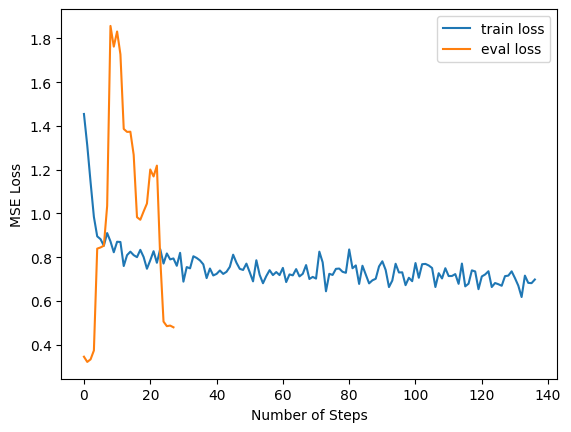

In [82]:
plt.plot([i for i in range(len(train_loss_plot))], train_loss_plot, label="train loss")
plt.plot([i for i in range(len(eval_loss_plot))], eval_loss_plot, label="eval loss")

plt.ylabel("MSE Loss")
plt.xlabel("Number of Steps")
plt.legend()
plt.show()

In [83]:
def plot_predictions(y_true, y_pred, param_names):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    for i, name in enumerate(param_names):
        plt.figure()
        plt.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.5)
        lims = [
            min(y_true[:, i].min(), y_pred[:, i].min()),
            max(y_true[:, i].max(), y_pred[:, i].max())
        ]
        plt.plot(lims, lims, "k--")
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(name)
        plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


Test MSE: 4.0377e-01


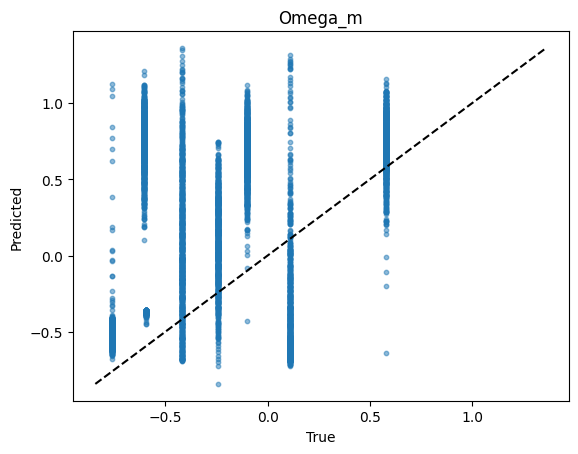

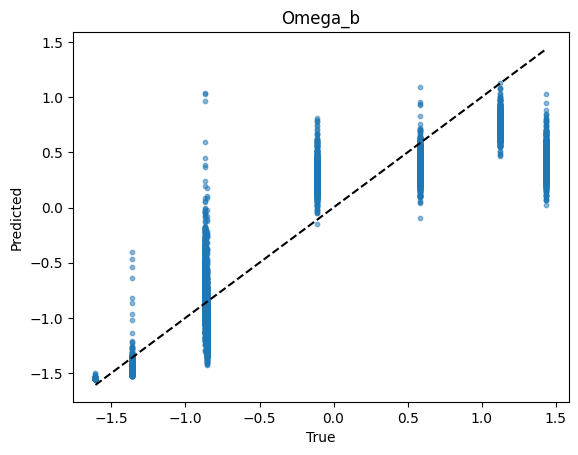

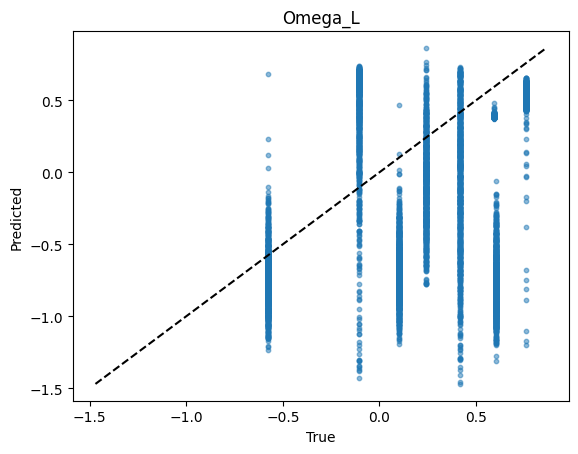

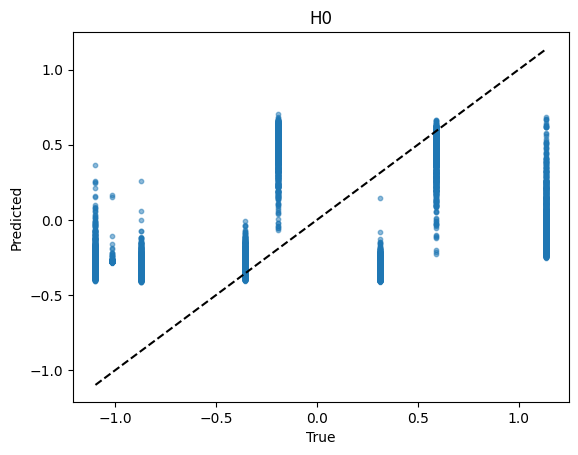

In [84]:
test_loss, y_test_true, y_test_pred, _ = evaluate(
    transformer, test_loader, criterion, device
)

print(f"Test MSE: {test_loss:.4e}")

plot_predictions(
    y_test_true,
    y_test_pred,
    param_names=["Omega_m", "Omega_b", "Omega_L", "H0"]
)